In [24]:
import matplotlib.pyplot as plt
import readsnapGadget2 as snap
import numpy as np
import pickle
from copy import copy
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
# read the simulation result
snapnum = 95
filename = f"data/snapshot_{str(snapnum).zfill(3)}"
head = snap.snapshot_header(filename) # read the header
pos = snap.read_block(filename, "POS ")
mass = snap.read_block(filename, "MASS")

# create copy of particle locations. It stores the locations of particles that have not been grouped yet.
particles = pos.copy()
n_particles = len(pos)

# linking length for friends of friends algo
boxsize = head.boxsize 
link_len = 0.2*(boxsize**3/n_particles)**(1/3) # kpc formula: 0.2*(V/N)^(1/3)

assert head.redshift < 1e-10 #present time
assert boxsize == 50000

In [3]:
print(f"The total number of particles is {n_particles}")

The total number of particles is 262144


In [4]:
# This calculates the 3d distance between the selected particle and all the other particles that have not been grouped
def distance(other_particles, particle):
    # get the differece in x, y, z coordinates
    dx = other_particles[:, 0] - particle[0]
    dy = other_particles[:, 1] - particle[1]
    dz = other_particles[:, 2] - particle[2]
    # account for periodic boundary conditions
    dx[dx > boxsize/2] = boxsize - dx[dx > boxsize/2]
    dy[dy > boxsize/2] = boxsize - dy[dy > boxsize/2]
    dz[dz > boxsize/2] = boxsize - dz[dz > boxsize/2]
    
    dist = (dx**2 + dy**2 + dz**2)**0.5
    return dist

In [ ]:
groups = {} # Positions of halo particles
sizes = {} # size of the halo (# of particles in it)
group_id = 0 # initial group id
pbar = tqdm(total=len(particles)) # progress bar

while len(particles) > 0:
    part = particles[0] # location of first particle
    dists = distance(particles, part)
    
    # add close-enough particles to the current group, and remove them
    mask = np.where(dists < link_len)[0]
    groups[group_id] = particles[mask]
    particles = np.delete(particles, mask, axis=0)
    
    '''Find the friends of friends of part'''
    pointer = 1 # for whom we are looking for more friends? the index of elements in groups[group_id]
    num_friends = len(groups[group_id])
    while pointer < num_friends:
        # get position and distances of the friend being considered, and which are close enough
        part_friend = groups[group_id][pointer]
        dists = distance(particles, part_friend)
        mask = np.where(dists < link_len)[0]
        
        # if we found friends of that friend, add to current group and delete from particle list
        if len(mask) > 0:
            friends_of_friend = particles[mask]
            groups[group_id] = np.concatenate([groups[group_id], friends_of_friend])
            particles = np.delete(particles, mask, axis=0)

        pointer +=1
        num_friends = len(groups[group_id])
    
    '''Current group completed. Move on to the next group'''
    sizes[group_id] = len(groups[group_id]) 
    group_id += 1
    pbar.update(1)

In [ ]:
pickle.dump(groups, open( "groups.pickle", "wb"))
pickle.dump(sizes, open("sizes.pickle", "wb"))

In [5]:
load_from_pkl = True
if load_from_pkl:
    groups = pickle.load(open( "groups.pickle", "rb" ))
    sizes = pickle.load(open( "sizes.pickle", "rb" ))

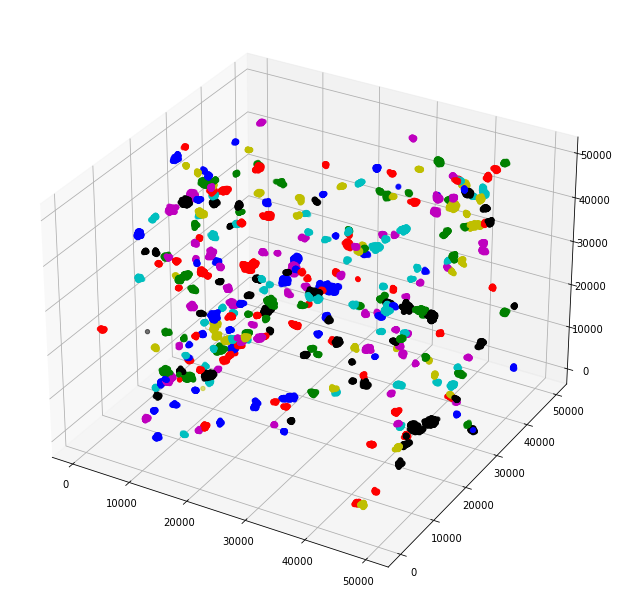

In [7]:
# Plot halos, one in each colour
colorlist = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
xs, ys, zs, col = [], [], [], []
for i in range(len(groups)):
    if sizes[i] > 50:
        for j in range(sizes[i]):
            xs += [groups[i][j][0]]
            ys += [groups[i][j][1]]
            zs += [groups[i][j][2]]
            col += [colorlist[i%7]]

fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='.', s=75, c=col)
plt.show()

In [9]:
groupsize_max = int(np.amax(np.fromiter(sizes.values(), dtype=float)))
biggest_halo_mass = groupsize_max*mass[0]
print(f"The largest halo (of total # {len(groups)}) has a mass of {biggest_halo_mass} x 10^10 solar masses.")
assert len(set(mass)) == 1

The largest halo (of total # 134021) has a mass of 8161.522034645081 x 10^10 solar masses.


# Finding the density profile of the largest halo

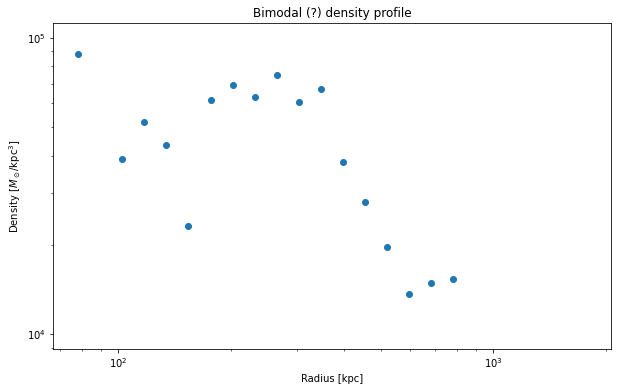

In [88]:
largest_group = groups[np.argmax(np.fromiter(sizes.values(), dtype=float))]
com_largest_halo = np.mean(largest_group, axis=0)
dists_from_com = [np.linalg.norm(np.array(k) - com_largest_halo) for k in largest_group]

closest_dist, largest_dist = min(dists_from_com), max(dists_from_com)
bins = np.logspace(np.log10(closest_dist), np.log10(largest_dist), num=25)
sphere_vols = np.array([(4/3)*np.pi*radius**3 for radius in bins])
sph_shell_vols = np.diff(sphere_vols)
cts, bin_edges = np.histogram(dists_from_com, bins=bins)
assert len(sph_shell_vols) == len(cts)
y_axis = cts*mass[0]*1e10/sph_shell_vols
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, y_axis)
plt.title("Bimodal (?) density profile")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Radius [kpc]");
plt.ylabel("Density [$M_\odot/\mathrm{kpc}^3$]");

This looks oddly bimodal, and not like the NFW profile at all. To figure out what's going on, let's plot the actual halo and the center of mass in real space.

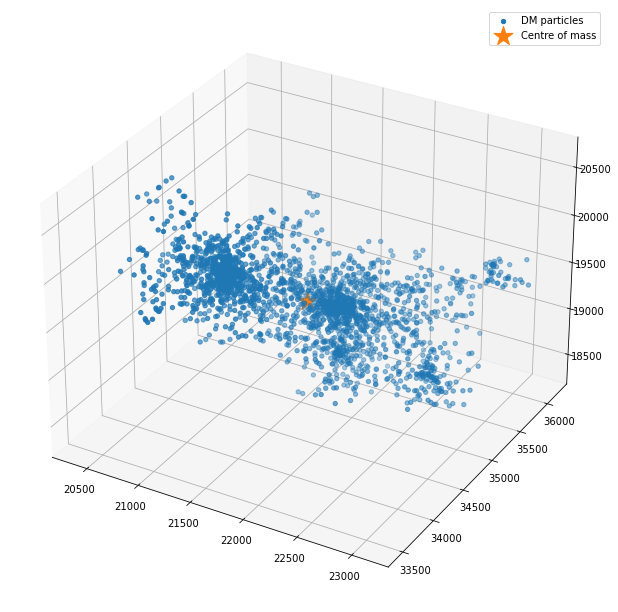

In [85]:
# Look to see if the centre of mass is in the right place
fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(largest_group[:,0], largest_group[:,1], largest_group[:,2],marker='.', s=75, label='DM particles')
ax.scatter(com_largest_halo[0], com_largest_halo[1], com_largest_halo[2], marker='*', s=400, label='Centre of mass')
plt.legend();
plt.show()

Indeed this was a weird halo. It seems like we've caught the two halos in the middle of merging. Thus, we move on to doing the same thing for the second largest galaxy, which will hopefully be an individual halo.

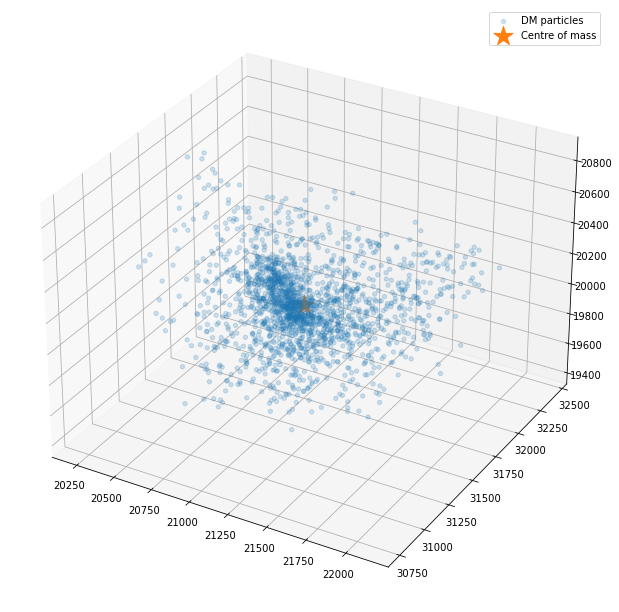

In [86]:
second_largest_group = groups[np.argsort(np.fromiter(sizes.values(), dtype=float))[-2]]
com_second_largest_halo = np.mean(second_largest_group, axis=0)
dists_from_com_2 = [np.linalg.norm(np.array(k) - com_second_largest_halo) for k in second_largest_group]

fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(second_largest_group[:,0], second_largest_group[:,1], second_largest_group[:,2],marker='.', s=75, alpha=0.2, label='DM particles')
ax.scatter(com_second_largest_halo[0], com_second_largest_halo[1], com_second_largest_halo[2], marker='*', s=400, label='Centre of mass')
plt.legend();
plt.show()

This looks much more like a usual DM halo. Thus we proceed to plotting the spherically averaged density profile.

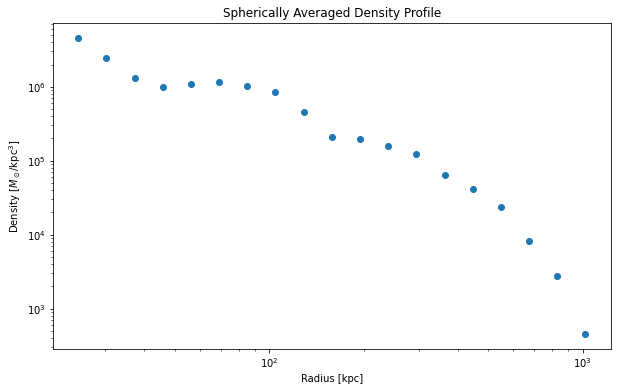

In [65]:
closest_dist_2, largest_dist_2 = min(dists_from_com_2), max(dists_from_com_2)
bins_2 = np.logspace(np.log10(closest_dist_2), np.log10(largest_dist_2), num=20)
sphere_vols = np.array([(4/3)*np.pi*radius**3 for radius in bins_2])
sph_shell_vols = np.diff(sphere_vols)
cts, bin_edges = np.histogram(dists_from_com_2, bins=bins_2)
assert len(sph_shell_vols) == len(cts)
densities = cts*mass[0]*1e10/sph_shell_vols
radii = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.figure(figsize=(10, 6))
plt.scatter(radii, densities)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Radius [kpc]");
plt.ylabel("Density [$M_\odot/\mathrm{kpc}^3$]");
plt.title("Spherically Averaged Density Profile");

Now we'll try to fit it with an NFW profile. This is
\begin{equation}
\rho(r) = \frac{\rho_0}{(r/a)(1+r/a)^2}.
\end{equation}
We'll fit for both $\rho_0$ and $a$, where $a$ is the scale radius.

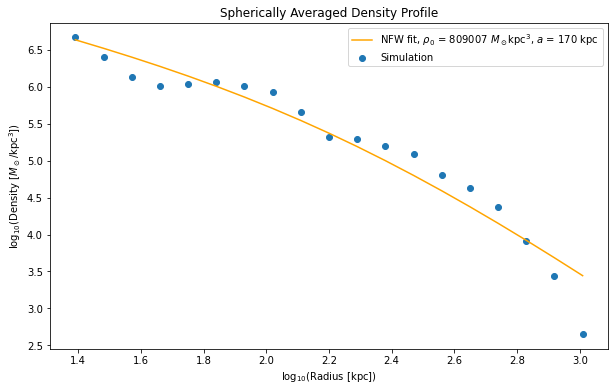

In [80]:
def log10nfw(log10r, log10rho0, log10a):
    return log10rho0 - log10r + log10a - 2*np.log10(1 + 10**(log10r)/10**(log10a))
popt, pcov = curve_fit(log10nfw, np.log10(radii), np.log10(densities), p0=[np.log10(10**8), np.log10(10**3)])
fit_rho0, fit_a = 10**popt

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(radii), np.log10(densities), label='Simulation')
plt.plot(np.log10(radii), log10nfw(np.log10(radii), *popt), label=rf'NFW fit, $\rho_0$ = {int(fit_rho0)} $M_\odot$kpc$^3$, $a$ = {int(fit_a)} kpc', c='orange')
plt.xlabel("log$_{10}$(Radius [kpc])");
plt.ylabel("log$_{10}$(Density [$M_\odot/\mathrm{kpc}^3$])");
plt.legend();
plt.title("Spherically Averaged Density Profile");

The concentration of the halo is defined as $c = R_\mathrm{vir}/a$. Taking the edge of the halo to be the virial radius $R_\mathrm{vir}$ and using the $a$ from our fit, we find the concentration.

In [82]:
rvir = radii[-1]
concentration = rvir/fit_a
print(concentration)

5.9797812259961685


Thus the concentration of the halo is 5.98.

# Halo mass function at redshift zero

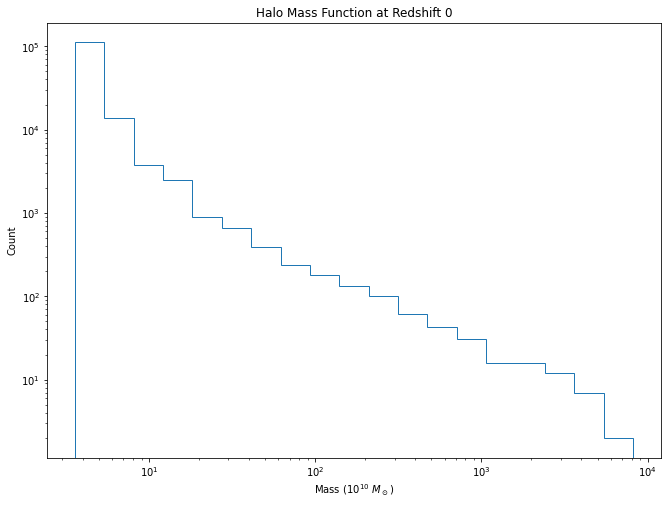

In [20]:
mass_of_halos = np.fromiter(sizes.values(), dtype=float)*mass[0]
mass_bins = np.logspace(np.log10(min(mass_of_halos)), np.log10(max(mass_of_halos)), num=20)
plt.figure(figsize=(11, 8))
plt.hist(mass_of_halos, bins=mass_bins, histtype='step')
plt.xscale('log')
plt.yscale('log')
plt.title("Halo Mass Function at Redshift 0")
plt.xlabel("Mass ($10^{10}\ M_\odot$)");
plt.ylabel("Count");

This looks good I guess?